<a href="https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cellpose3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running cellpose3 in colab with a GPU

<font size = 4>Cellpose3 now allows you to restore and segment noisy/blurry/low res images!

For more details on Cellpose3 check out the [paper](https://www.biorxiv.org/content/10.1101/2024.02.10.579780v1).

Mount your google drive to access all your image files. This also ensures that the segmentations are saved to your google drive.

## Installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

Check CUDA version and that GPU is working in cellpose and import other libraries.

In [1]:
!nvcc --version
!nvidia-smi

import os, shutil
import sys

dir_cellpose = f"{os.path.dirname(os.getcwd())}"
sys.path.append(dir_cellpose)

import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_19:00:59_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
Thu Jan 23 16:34:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:01:00.0  On |                  Off |
|  0% 

## Images

Load in your own data or use ours (below)

100%|██████████| 28.0M/28.0M [00:03<00:00, 7.96MB/s]


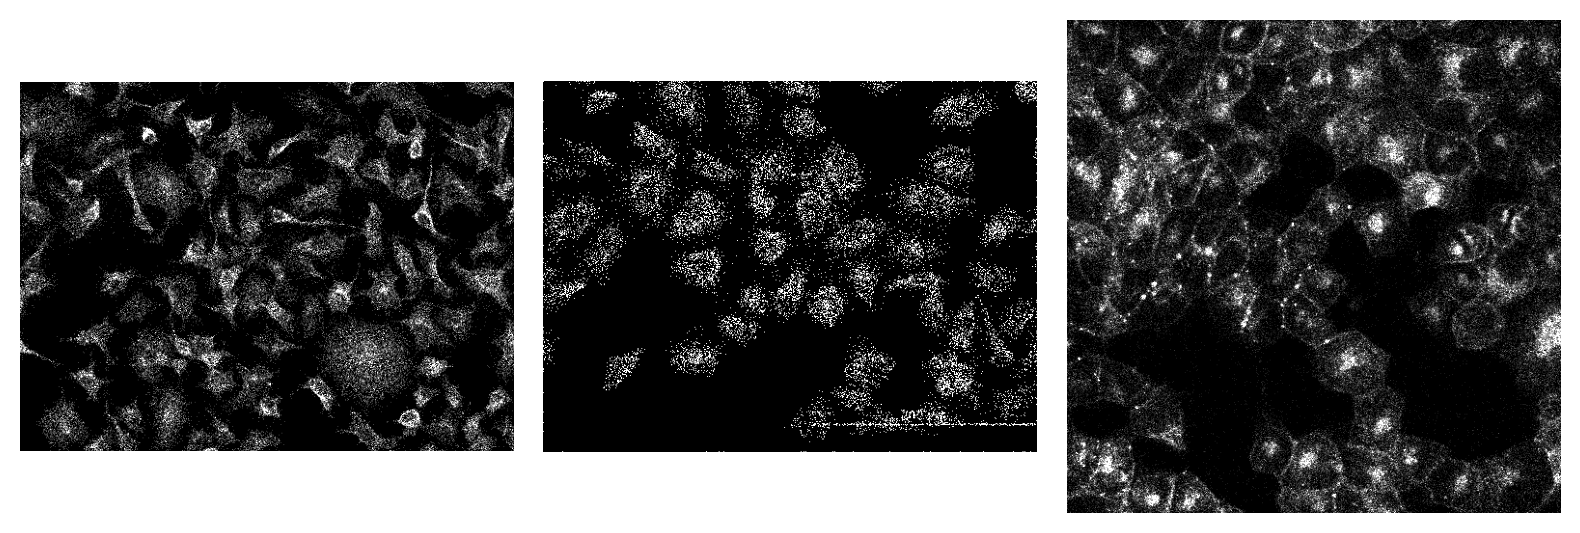

In [2]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 200
from cellpose import utils, io

# download noisy images from website
url = "http://www.cellpose.org/static/data/test_poisson.npz"
filename = "test_poisson.npz"
utils.download_url_to_file(url, filename)
dat = np.load(filename, allow_pickle=True)["arr_0"].item()

imgs = dat["test_noisy"]
plt.figure(figsize=(8,3))
for i, iex in enumerate([2, 18, 20]):
    img = imgs[iex].squeeze()
    plt.subplot(1,3,1+i)
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.axis('off')
plt.tight_layout()
plt.show()

Mount your google drive here if you want to load your own images:

In [ ]:

#@markdown ###Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')


## run denoising and segmentation

In [11]:
diams

array([29.09818374, 29.07600041, 33.01332554, 39.98172066, 30.84007036,
       39.10448431, 24.12199146, 26.70232471, 32.43913878, 39.5254971 ,
       32.50532349, 52.24773281, 22.45446191, 22.56758334, 23.17982033,
       20.27943262, 24.79868343, 50.23505527, 36.05520178, 31.65500785,
       51.38151726, 32.09437985, 48.50718172, 20.86738901, 18.98227571,
       15.26443044, 18.19456737, 14.22831992, 31.65500785, 35.94011723,
       21.90916038, 44.88056327, 25.69371876, 20.46694433, 52.22944377,
       36.15213125, 54.03275188, 25.98941762, 47.61973991, 17.22396046,
       30.31954788, 31.52374079, 14.27299293, 49.64835881, 24.42235456,
       69.93179449, 15.8168178 , 41.57311142, 21.14017692, 30.59132774,
       23.48004946, 63.9700925 , 14.88434348, 11.88821221, 62.04069813,
       46.70181303, 55.14069308, 29.82194819, 57.37021305, 44.61020231,
       41.96295235, 23.2757116 , 36.143378  , 81.57955075, 32.13239991,
       26.73799658, 50.36721101, 48.04563762])

In [5]:
# RUN CELLPOSE3

from cellpose import denoise, io

io.logger_setup() # run this to get printing of progress

# DEFINE CELLPOSE MODEL
# model_type="cyto3" or "nuclei", or other model
# restore_type: "denoise_cyto3", "deblur_cyto3", "upsample_cyto3", "denoise_nuclei", "deblur_nuclei", "upsample_nuclei"
model = denoise.CellposeDenoiseModel(gpu=True, model_type="cyto3",
                                     restore_type="upsample_nuclei")

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus
# OR if you have different types of channels in each image
# channels = [[2,3], [0,0], [0,0]]

# if you have a nuclear channel, you can use the nuclei restore model on the nuclear channel with
# model = denoise.CellposeDenoiseModel(..., chan2_restore=True)

# NEED TO SPECIFY DIAMETER OF OBJECTS
# in this case we have them from the ground-truth masks
diams = dat["diam_test"]

masks, flows, styles, imgs_dn = model.eval(imgs, diameter=diams, channels=[0,0])


creating new log file
2025-01-23 16:37:55,995 [INFO] WRITING LOG OUTPUT TO C:\Users\HyperPC_Smee\.cellpose\run.log
2025-01-23 16:37:55,995 [INFO] 
cellpose version: 	3.1.0 
platform:       	win32 
python version: 	3.8.19 
torch version:  	2.3.1
2025-01-23 16:37:55,996 [INFO] Downloading: "https://www.cellpose.org/models/upsample_nuclei" to C:\Users\HyperPC_Smee\.cellpose\models\upsample_nuclei



100%|██████████| 25.4M/25.4M [00:02<00:00, 10.3MB/s]

2025-01-23 16:37:59,371 [INFO] >> upsample_nuclei << model set to be used
2025-01-23 16:37:59,372 [INFO] ** TORCH CUDA version installed and working. **
2025-01-23 16:37:59,373 [INFO] >>>> using GPU (CUDA)
2025-01-23 16:37:59,503 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-01-23 16:37:59,504 [INFO] >> cyto3 << model set to be used
2025-01-23 16:37:59,505 [INFO] ** TORCH CUDA version installed and working. **
2025-01-23 16:37:59,506 [INFO] >>>> using GPU (CUDA)


2025-01-23 16:37:59,556 [INFO] >>>> loading model C:\Users\HyperPC_Smee\.cellpose\models\cyto3
2025-01-23 16:37:59,620 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-01-23 16:37:59,621 [INFO] 0%|          | 0/68 [00:00<?, ?it/s]
2025-01-23 16:37:59,622 [WARNING] not interpolating image before upsampling because diameter is set >= 17.0
2025-01-23 16:37:59,742 [WARNING] not interpolating image before upsampling because diameter is set >= 17.0
2025-01-23 16:37:59,833 [WARNING] not interpolating image before upsampling because diameter is set >= 17.0
2025-01-23 16:37:59,842 [WARNING] not interpolating image before upsampling because diameter is set >= 17.0
2025-01-23 16:37:59,884 [WARNING] not interpolating image before upsampling because diameter is set >= 17.0
2025-01-23 16:37:59,894 [WARNING] not interpolating image before upsampling because diameter is set >= 17.0
2025-01-23 16:37:59,906 [WARNING] not interpolating image before upsampling becaus

plot results

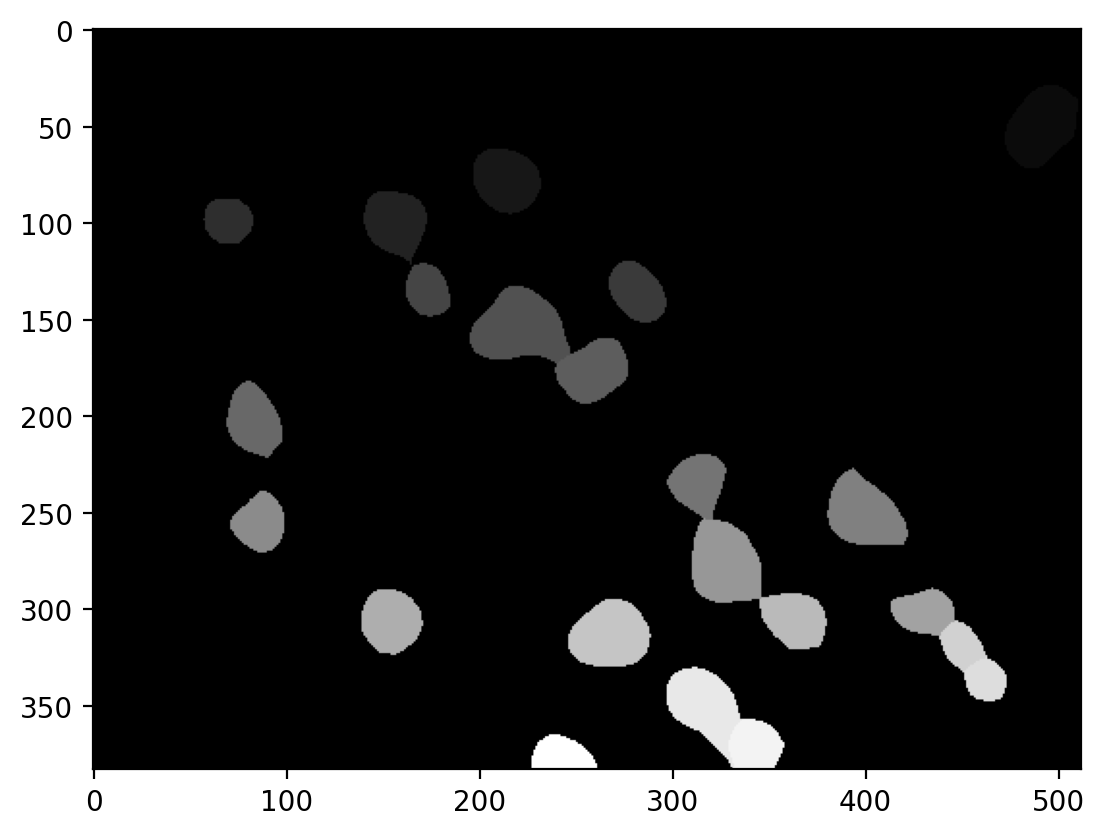

In [6]:
plt.imshow(masks[0], cmap='gray')

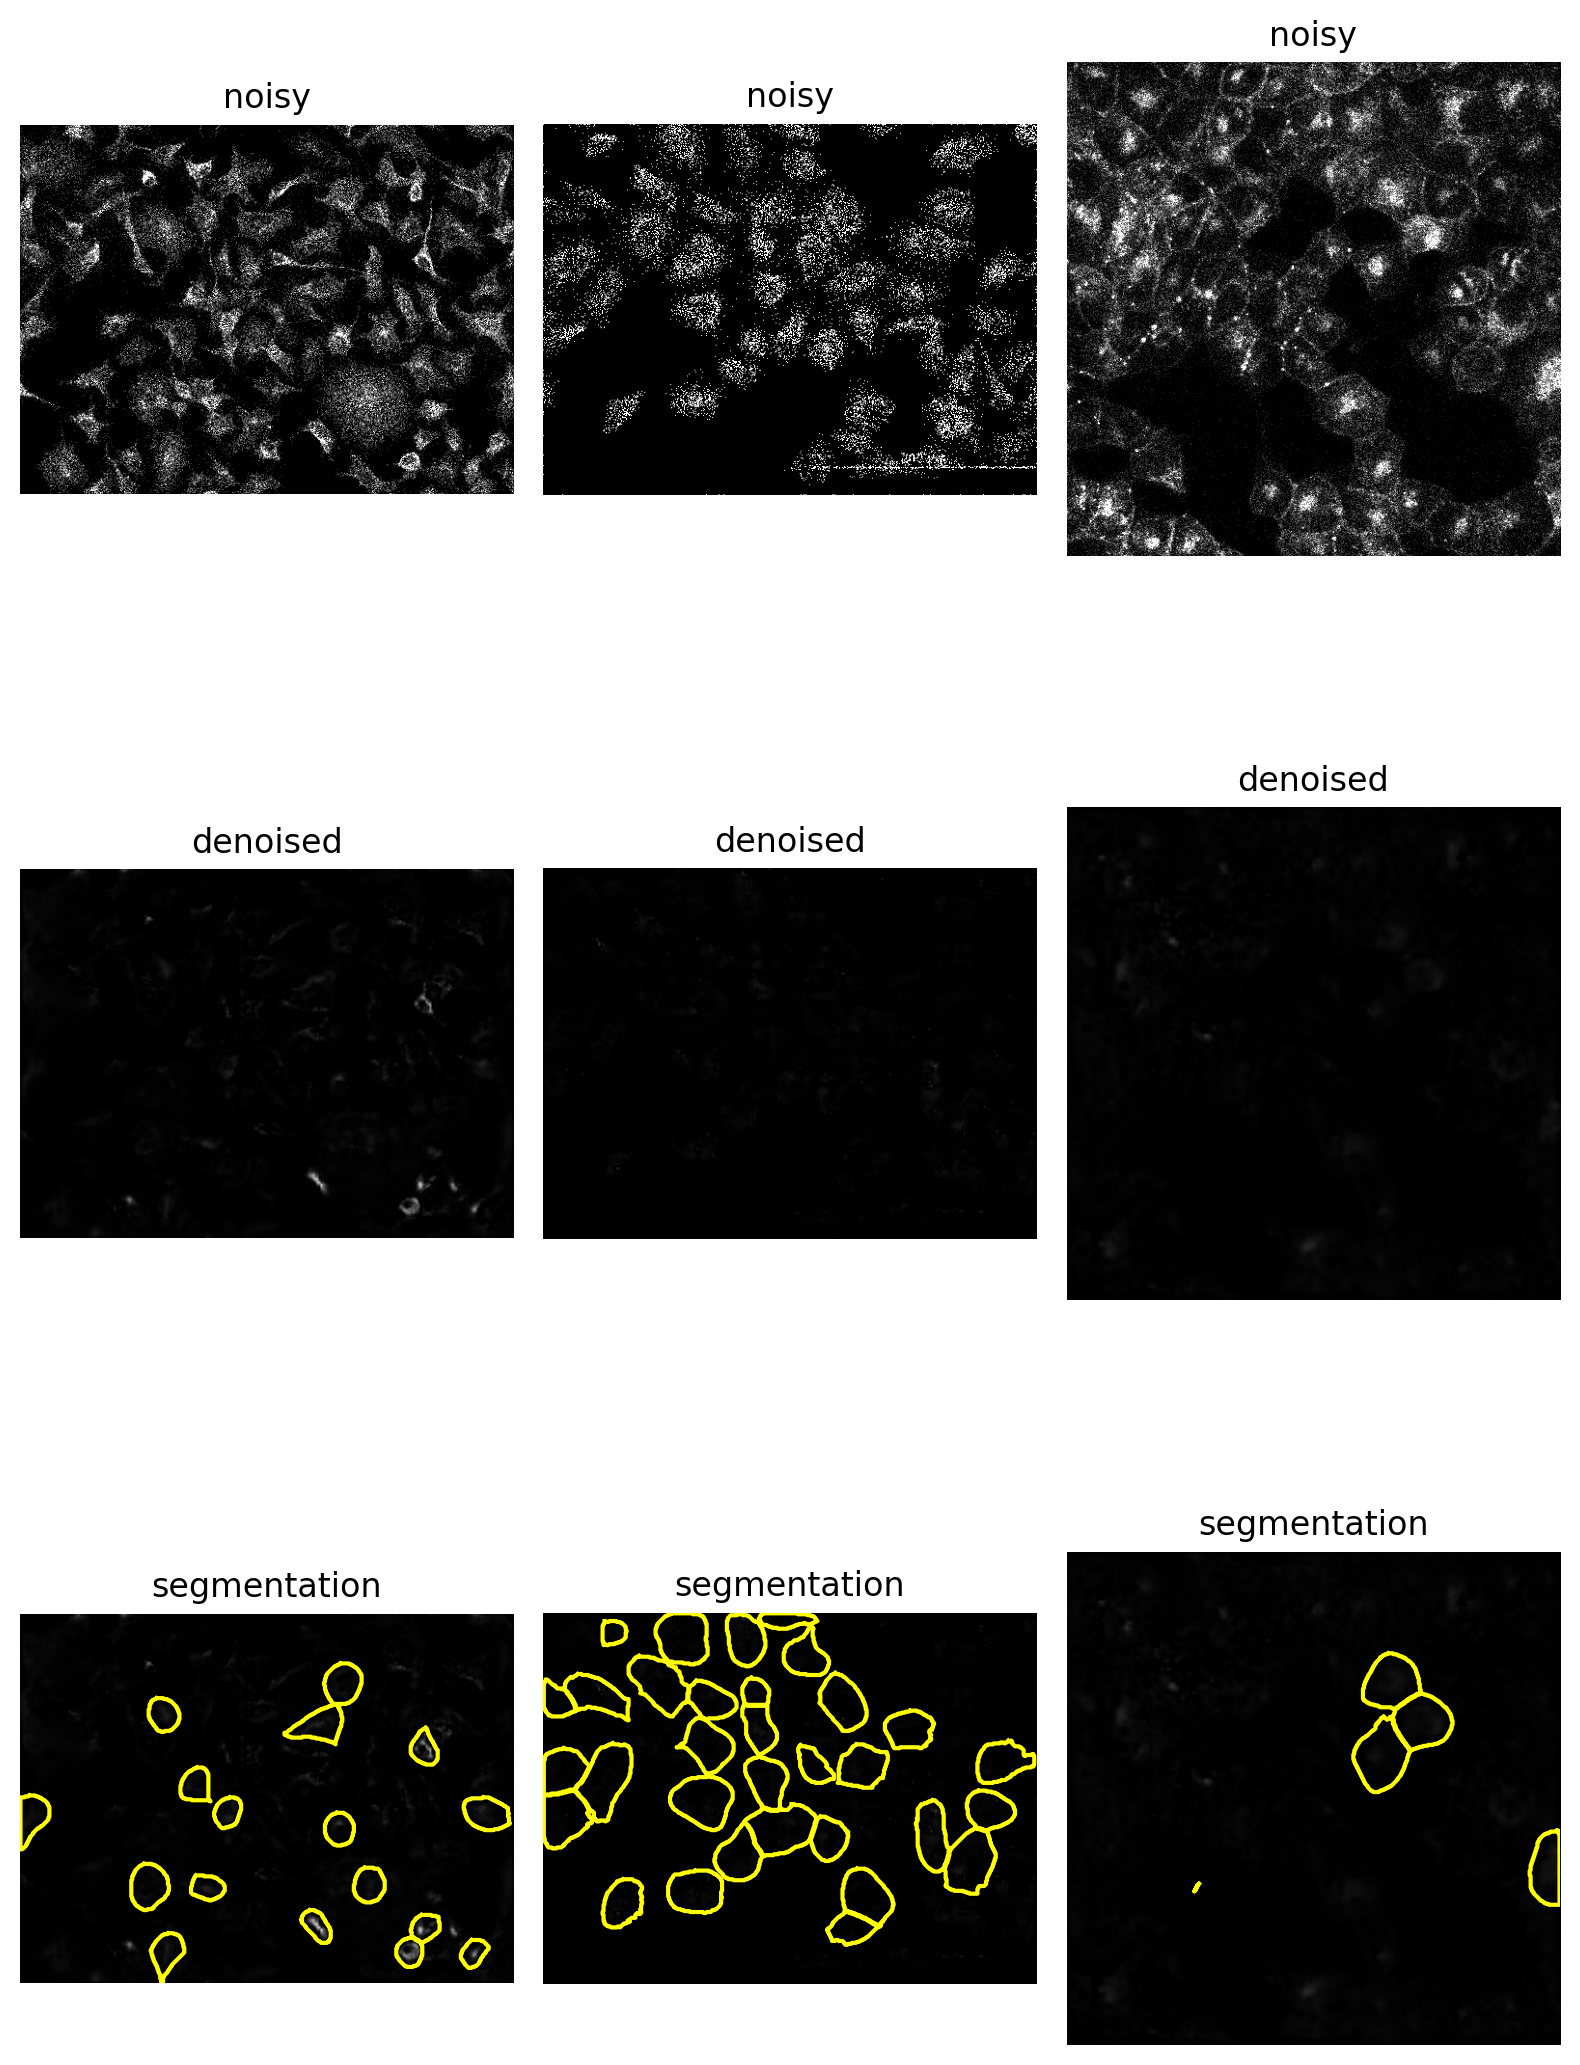

In [7]:
plt.figure(figsize=(8,12))
for i, iex in enumerate([2, 18, 20]):
    img = imgs[iex].squeeze()
    plt.subplot(3,3,1+i)
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.axis('off')
    plt.title("noisy")

    img_dn = imgs_dn[iex].squeeze()
    plt.subplot(3,3,4+i)
    plt.imshow(img_dn, cmap="gray", vmin=0, vmax=1)
    plt.axis('off')
    plt.title("denoised")

    plt.subplot(3,3,7+i)
    plt.imshow(img_dn, cmap="gray", vmin=0, vmax=1)
    outlines = utils.outlines_list(masks[iex])
    for o in outlines:
        plt.plot(o[:,0], o[:,1], color=[1,1,0])
    plt.axis('off')
    plt.title("segmentation")

plt.tight_layout()
plt.show()